In [13]:
import pandas as pd
import numpy as np
import os
from ast import literal_eval

pd.options.mode.chained_assignment = None

In [14]:
data_path = "./data"
if os.listdir(data_path) != ['tmdb_5000_credits.csv', 'tmdb_5000_movies.csv']:
    print("[ERROR] Please download and unzip the dataset in a subdirectory './data'.")
else:
    print("[INFO] The dataset is correctly placed.")

[INFO] The dataset is correctly placed.


### Loading the data

In [15]:
tmdb_credits = pd.read_csv(os.path.join(data_path, "tmdb_5000_credits.csv"))
tmdb_credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [16]:
tmdb_movies = pd.read_csv(os.path.join(data_path, "tmdb_5000_movies.csv"))
tmdb_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


### Cleaning the datasets
#### Cleaning tmdb credits

In [17]:
literal_eval(tmdb_credits.cast[0])

def mapping_casts(list_casts, useful_keys = {"id", "gender", "name"}):
    """Mapping casts to keep useful information."""
    result = []
    for cast in list_casts:
        filtering = {k:v for k,v in cast.items() if k in useful_keys}
        if len(filtering) == len(useful_keys):
            result.append(filtering)
    return result
mapping_casts(literal_eval(tmdb_credits.cast[0]))[:5]

[{'gender': 2, 'id': 65731, 'name': 'Sam Worthington'},
 {'gender': 1, 'id': 8691, 'name': 'Zoe Saldana'},
 {'gender': 1, 'id': 10205, 'name': 'Sigourney Weaver'},
 {'gender': 2, 'id': 32747, 'name': 'Stephen Lang'},
 {'gender': 1, 'id': 17647, 'name': 'Michelle Rodriguez'}]

In [18]:
L = literal_eval(tmdb_credits.crew[0])

def mapping_crew(list_crew, useful_keys = {"id", "job", "name", "gender"}, keeping_jobs = {"Original Music Composer", "Director"}):
    """Mapping crew to keep useful information."""
    result = []
    for person in list_crew:
        filtering = {k:v for k,v in person.items() if (k in useful_keys and person["job"] in keeping_jobs)}
        if filtering != {} and len(filtering) == len(useful_keys):            
            result.append(filtering)
    return result

mapping_crew(L)

[{'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'gender': 2, 'id': 2710, 'job': 'Director', 'name': 'James Cameron'}]

In [19]:
tmdb_credits_clean = tmdb_credits.copy()
tmdb_credits_clean['cast'] = tmdb_credits_clean['cast'].apply(lambda x: mapping_casts(literal_eval(x)))
tmdb_credits_clean['crew'] = tmdb_credits_clean['crew'].apply(lambda x: mapping_crew(literal_eval(x)))
tmdb_credits_clean.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{'gender': 2, 'id': 65731, 'name': 'Sam Worth...","[{'gender': 2, 'id': 1729, 'job': 'Original Mu..."
1,285,Pirates of the Caribbean: At World's End,"[{'gender': 2, 'id': 85, 'name': 'Johnny Depp'...","[{'gender': 2, 'id': 1704, 'job': 'Director', ..."
2,206647,Spectre,"[{'gender': 2, 'id': 8784, 'name': 'Daniel Cra...","[{'gender': 2, 'id': 153, 'job': 'Original Mus..."
3,49026,The Dark Knight Rises,"[{'gender': 2, 'id': 3894, 'name': 'Christian ...","[{'gender': 2, 'id': 947, 'job': 'Original Mus..."
4,49529,John Carter,"[{'gender': 2, 'id': 60900, 'name': 'Taylor Ki...","[{'gender': 2, 'id': 7, 'job': 'Director', 'na..."


In [20]:
tmdb_credits_clean_cast = tmdb_credits_clean[["movie_id", "title", "cast"]].explode("cast")

def get_gender(cast):
    splitted = str(cast).split()
    if len(splitted)>1:
        return splitted[1][0]
    else:
        -1
        
def get_id(cast):
    splitted = str(cast).split()
    if len(splitted)>1:
        return splitted[3].replace(",", "")
    else:
        -1
        
def get_name(cast):
    splitted = str(cast).split(", ")
    if len(splitted)>1:
        return splitted[2].replace("'", "").replace(",", "").replace("name: ", "").replace("}", "")
    else:
        -1

tmdb_credits_clean_cast['gender'] = tmdb_credits_clean_cast.cast.apply(get_gender)
tmdb_credits_clean_cast = tmdb_credits_clean_cast[tmdb_credits_clean_cast.gender != -1]

tmdb_credits_clean_cast['person_id'] = tmdb_credits_clean_cast.cast.apply(get_id)
tmdb_credits_clean_cast = tmdb_credits_clean_cast[tmdb_credits_clean_cast.person_id != -1]

tmdb_credits_clean_cast['name'] = tmdb_credits_clean_cast.cast.apply(get_name)
tmdb_credits_clean_cast = tmdb_credits_clean_cast[tmdb_credits_clean_cast.name != -1]

tmdb_credits_clean_cast['job'] = "actor"
tmdb_credits_clean_cast.drop(columns=['cast'], inplace=True)
tmdb_credits_clean_cast.head()

,movie_id,title,gender,person_id,name,job
0,19995,Avatar,2,65731,Sam Worthington,actor
0,19995,Avatar,1,8691,Zoe Saldana,actor
0,19995,Avatar,1,10205,Sigourney Weaver,actor
0,19995,Avatar,2,32747,Stephen Lang,actor
0,19995,Avatar,1,17647,Michelle Rodriguez,actor


In [21]:
tmdb_credits_clean_crew = tmdb_credits_clean[["movie_id", "title", "crew"]].explode("crew")

        
def get_name_crew(crew):
    splitted = str(crew).split(': ')
    if len(splitted)>1:
        return splitted[4].replace(",", "").replace("'", "").replace("}", "")
    else:
        -1
        
def get_job(crew):
    splitted = str(crew).split(" '")
    if len(splitted)>1:
        return splitted[3].replace("'", "").replace(",", "")
    else:
        -1
    



tmdb_credits_clean_crew['gender'] = tmdb_credits_clean_crew.crew.apply(get_gender)
tmdb_credits_clean_crew = tmdb_credits_clean_crew[tmdb_credits_clean_crew.gender != -1]

tmdb_credits_clean_crew['person_id'] = tmdb_credits_clean_crew.crew.apply(get_id)
tmdb_credits_clean_crew = tmdb_credits_clean_crew[tmdb_credits_clean_crew.person_id != -1]

tmdb_credits_clean_crew['name'] = tmdb_credits_clean_crew.crew.apply(get_name_crew)
tmdb_credits_clean_crew = tmdb_credits_clean_crew[tmdb_credits_clean_crew.name != -1]

tmdb_credits_clean_crew['job'] = tmdb_credits_clean_crew.crew.apply(get_job)
tmdb_credits_clean_crew = tmdb_credits_clean_crew[tmdb_credits_clean_crew.job != -1]
tmdb_credits_clean_crew.drop(columns=['crew'], inplace=True)
tmdb_credits_clean_crew.head()

,movie_id,title,gender,person_id,name,job
0,19995,Avatar,2,1729,James Horner,Original Music Composer
0,19995,Avatar,2,2710,James Cameron,Director
1,285,Pirates of the Caribbean: At World's End,2,1704,Gore Verbinski,Director
1,285,Pirates of the Caribbean: At World's End,2,947,Hans Zimmer,Original Music Composer
2,206647,Spectre,2,153,Thomas Newman,Original Music Composer


### Some statistics about the dataset

In [34]:
tmdb_movies.count()

budget                  4803
genres                  4803
homepage                1712
id                      4803
keywords                4803
original_language       4803
original_title          4803
overview                4800
popularity              4803
production_companies    4803
production_countries    4803
release_date            4802
revenue                 4803
runtime                 4801
spoken_languages        4803
status                  4803
tagline                 3959
title                   4803
vote_average            4803
vote_count              4803
dtype: int64

We have some missing values but not that much for important columns.
We have 4803 movies in total.

In [37]:
tmdb_credits_clean_cast['name'].drop_duplicates().count()

54196

There are 54196 different actors in total in the dataset, and this high number will be useful to plot networks of actors.

## Getting some datasets to further visualization

#### Movie/year

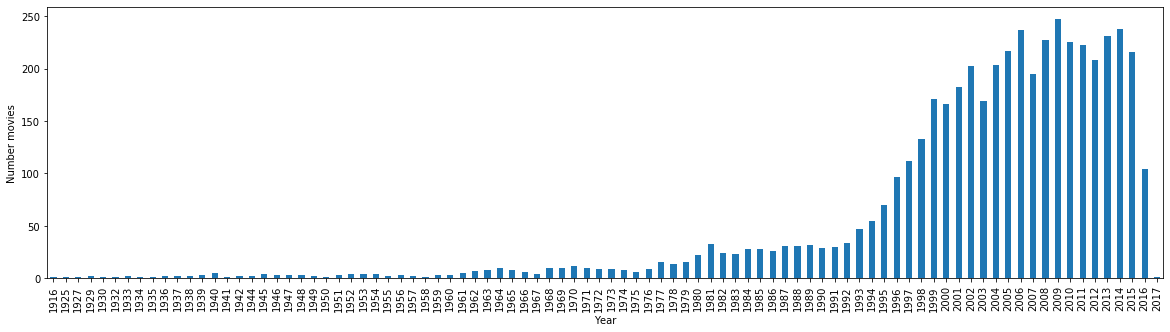

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

movie_per_year = tmdb_movies[['original_title', 'release_date']].dropna()
movie_per_year['release_date'] = movie_per_year['release_date'].apply(lambda x: int(str(x).split("-")[0])).astype("int64")
#movie_per_year = movie_per_year[movie_per_year.release_date < 2017]
movie_per_year['release_date'].value_counts(sort=False, ascending=True).sort_index().plot(kind='bar')
plt.xlabel("Year")
plt.ylabel("Number movies")
plt.show()

We seem to have a lot of missing values since 2016 and we could work with the previous years if necessary.
The dataset covers films from 1916 until 2015.

#### Budget/profit

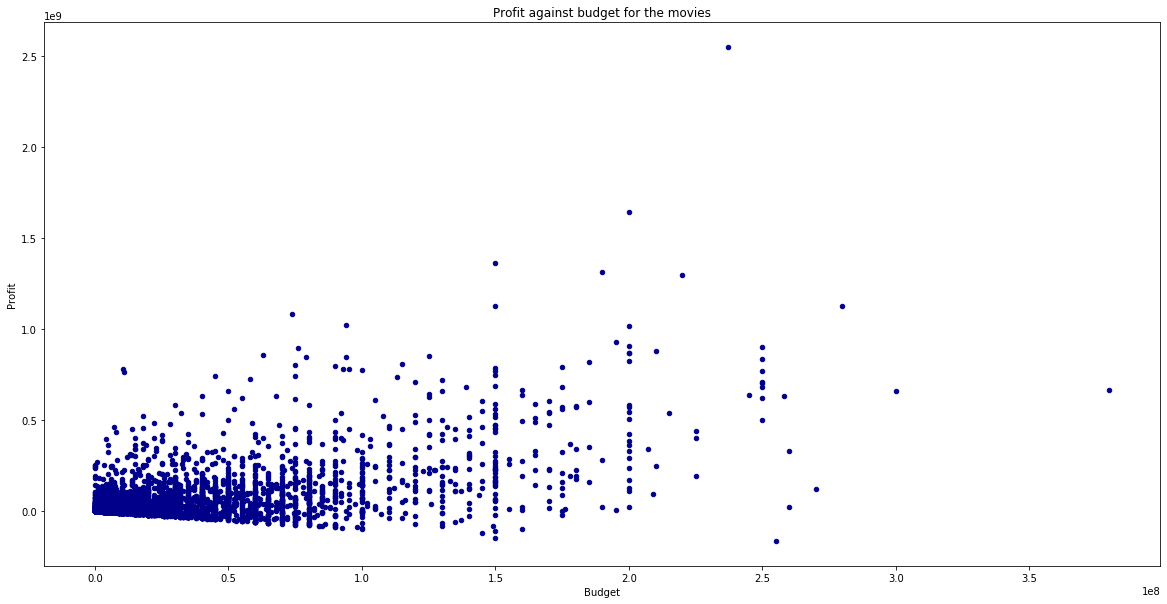

In [32]:
plt.rcParams['figure.figsize'] = [20, 10]
budget_profit = tmdb_movies[['budget', 'revenue']]
budget_profit['profit'] = budget_profit['revenue'] - budget_profit['budget']
budget_profit.plot.scatter(x='budget',
                      y='profit',
                      c='DarkBlue')
plt.xlabel("Budget")
plt.ylabel("Profit")
plt.title("Profit against budget for the movies")

plt.show()

We see that high budget doesn't always mean high profit.

#### Num_movies/genre

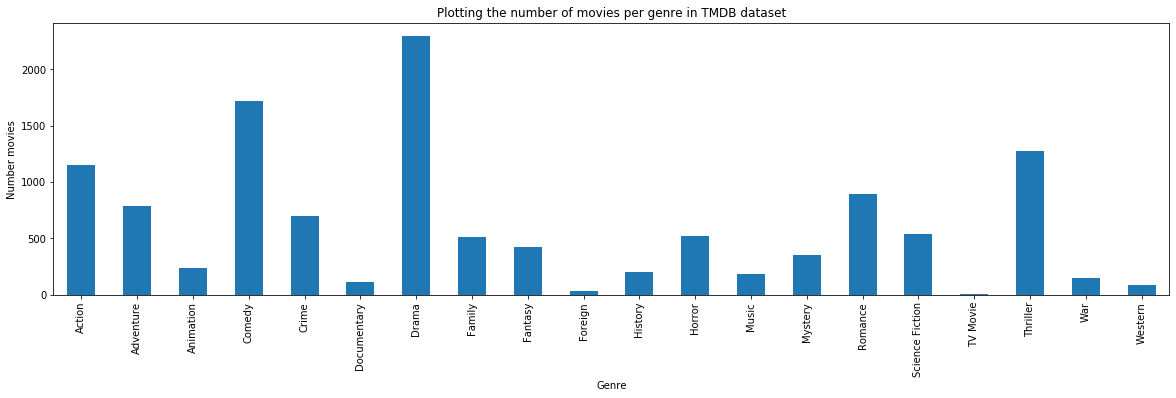

In [31]:
import numpy as np

def parse_genres(genres):
    L=[]
    for genre in genres:
        L.append(genre['name'])
    if len(L) == 0:
        return np.nan
    return L

movie_genres = tmdb_movies[["id", "genres"]]
movie_genres["genres"] = movie_genres.genres.apply(lambda x: parse_genres(literal_eval(x)))
movie_genres = movie_genres.dropna().explode("genres")
movie_genres['genres'].value_counts(sort=False, ascending=True).sort_index().plot(kind='bar')
plt.xlabel("Genre")
plt.ylabel("Number movies")
plt.title("Plotting the number of movies per genre in TMDB dataset")
plt.show()


Drama, comedy, action and thriller are the most common genres to be found in films.